In [6]:
import optuna
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import mlflow.xgboost
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import mlflow
import pandas as pd
mlflow.set_tracking_uri("http://127.0.0.1:5000")
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Load dữ liệu Breast Cancer
data = load_breast_cancer()
X = data.data
y = data.target

# Tách dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Chuyển tập huấn luyện và tập kiểm tra thành DataFrame
train_df = pd.DataFrame(X_train, columns=data.feature_names)
train_df['target'] = y_train
test_df = pd.DataFrame(X_test, columns=data.feature_names)
test_df['target'] = y_test

# Lưu tập huấn luyện và tập kiểm tra thành tệp CSV
train_csv_path = 'train_data.csv'
test_csv_path = 'test_data.csv'
train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

In [8]:

# Hàm mục tiêu để tối ưu tham số sử dụng F1-score và ghi thông tin vào MLflow
def objective(trial):
    with mlflow.start_run():
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 9),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 1e-8, 1.0,  log=True),
            'subsample': trial.suggest_float('subsample', 0.01, 1.0, log=True),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
            'eval_metric': 'mlogloss',
            'use_label_encoder': False
        }
        model = xgb.XGBClassifier(**params, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)

        mlflow.log_params(params)
        mlflow.xgboost.log_model(model, "best_xgboost_model")
        mlflow.log_metric("F1-score", f1)
        mlflow.log_artifact(train_csv_path, artifact_path='data')
        mlflow.log_artifact(test_csv_path, artifact_path='data')
        return f1  # Optuna tìm giá trị tối ưu bằng cách tối đa hóa mục tiêu

# Tạo một study để tối ưu hóa
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Lấy thông tin về mô hình tốt nhất
best_trial = study.best_trial
best_params = best_trial.params
best_f1 = best_trial.value


[I 2023-09-30 11:14:21,896] A new study created in memory with name: no-name-d76eab80-537b-4026-9b56-8ba1b1e77d33
[I 2023-09-30 11:14:23,826] Trial 0 finished with value: 0.7675675675675676 and parameters: {'max_depth': 2, 'learning_rate': 0.593007142489898, 'n_estimators': 70, 'min_child_weight': 6, 'gamma': 0.0067818471137063765, 'subsample': 0.055704835274541925, 'colsample_bytree': 0.013920650128365625, 'reg_alpha': 7.642290648025155e-07, 'reg_lambda': 1.1378241749714236e-05}. Best is trial 0 with value: 0.7675675675675676.
[I 2023-09-30 11:14:25,646] Trial 1 finished with value: 0.993006993006993 and parameters: {'max_depth': 7, 'learning_rate': 0.023563885320382894, 'n_estimators': 385, 'min_child_weight': 3, 'gamma': 2.157723229015672e-07, 'subsample': 0.16845636387083276, 'colsample_bytree': 0.11174271977799694, 'reg_alpha': 5.134268266913751e-07, 'reg_lambda': 0.002812497593054852}. Best is trial 1 with value: 0.993006993006993.
[I 2023-09-30 11:14:27,488] Trial 2 finished wit

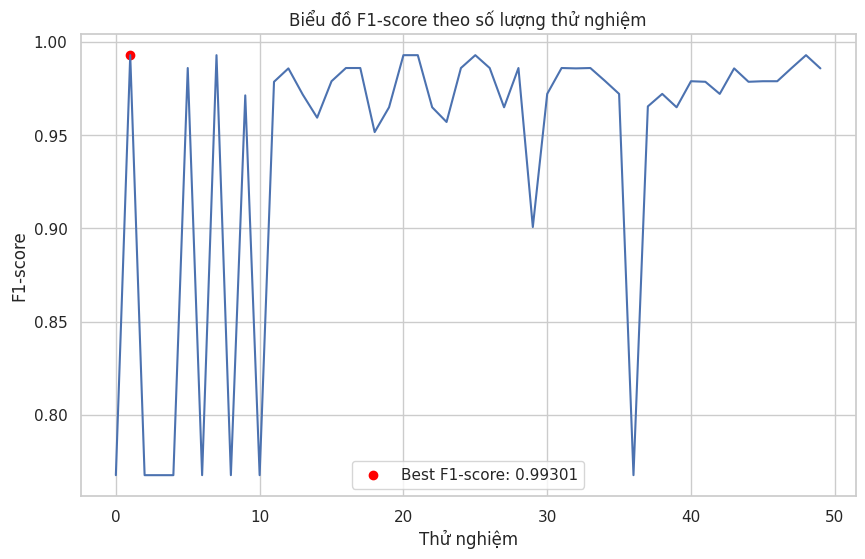

In [9]:
# Vẽ biểu đồ F1-score
f1_scores = [trial.value for trial in study.trials]
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(f1_scores)), y=f1_scores)
plt.xlabel("Thử nghiệm")
plt.ylabel("F1-score")
plt.title("Biểu đồ F1-score theo số lượng thử nghiệm")
plt.scatter([best_trial.number], [best_f1], color='red', label=f'Best F1-score: {best_f1:.5f}')
plt.legend()
plt.show()

In [10]:
X_test[0]

array([1.247e+01, 1.860e+01, 8.109e+01, 4.819e+02, 9.965e-02, 1.058e-01,
       8.005e-02, 3.821e-02, 1.925e-01, 6.373e-02, 3.961e-01, 1.044e+00,
       2.497e+00, 3.029e+01, 6.953e-03, 1.911e-02, 2.701e-02, 1.037e-02,
       1.782e-02, 3.586e-03, 1.497e+01, 2.464e+01, 9.605e+01, 6.779e+02,
       1.426e-01, 2.378e-01, 2.671e-01, 1.015e-01, 3.014e-01, 8.750e-02])